In [2]:
# This is a Bayesian Neural Network implementation using TensorFlow for a simple y = sin(x) function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# Check if GPU is available
print("GPU Available: ", tf.test.is_gpu_available())
print("GPU Name: ", tf.test.gpu_device_name())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
GPU Name:  /device:GPU:0


x shape: (1000,)
t shape: (1000,)
u0: (1000,)
U_1D shape: (1000,)
X shape: (1000, 1000)
T shape: (1000, 1000)
U shape: (1000, 1000)


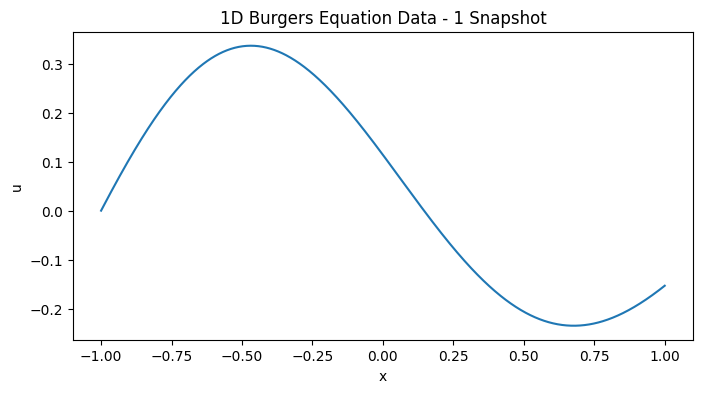

'# Plot the initial condition\nplt.figure(figsize=(8, 6))\nplt.pcolormesh(X, T, U, shading=\'auto\')\nplt.colorbar()\nplt.xlabel(\'x\')\nplt.ylabel(\'t\')\nplt.title("Burger\'s Equation Solution")\nplt.show()'

In [4]:
# Define the parameters for the Burger's equation
nu = 0.2 / np.pi  # Viscosity
N = 1000  # Number of data points

# Generate the spatial domain
x = np.linspace(-1, 1, N)
t = np.linspace(0, 1, N)
X, T = np.meshgrid(x, t)

# Initial condition
u0 = -np.sin(np.pi * x)

# Generate the dataset
def burgers_exact(x, t, nu):
    return -2 * nu * np.pi * np.sin(np.pi * (x - 4 * nu * t)) * np.exp(-np.pi**2 * nu * t)
# Exact solution: u(x, t) = -2 * nu * pi * sin(pi * (x - 4 * nu * t)) * exp(-pi^2 * nu * t)
# If t = 0, u(x, 0) = -2 * nu * pi * sin(pi * x) = -2 * 0.01/pi * pi * sin(pi * x) = -0.02 * sin(pi * x)
# If t = 1, u(x, 1) = -2 * nu * pi * sin(pi * (x - 4 * nu)) = -2 * 0.01/pi * pi * sin(pi * (x - 4 * 0.01/pi)) = -0.02 * sin(pi * (x - 4 * 0.01/pi))

U_1D = burgers_exact(x, t, nu)
U = burgers_exact(X, T, nu)

# Plot sizes of all the data
print("x shape:", x.shape)
print("t shape:", t.shape)
print("u0:", u0.shape)
print("U_1D shape:", U_1D.shape)
print("X shape:", X.shape)
print("T shape:", T.shape)
print("U shape:", U.shape)

plt.figure(figsize=(8, 4))
plt.plot(x, U_1D)
plt.xlabel('x')
plt.ylabel('u')
plt.title('1D Burgers Equation Data - 1 Snapshot')
plt.show()

'''# Plot the initial condition
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, T, U, shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Burger's Equation Solution")
plt.show()'''

x shape: (1000,)
t shape: (1000,)
u0: (1000,)
U_1D shape: (1000,)
X shape: (1000, 1000)
T shape: (1000, 1000)
U shape: (1000, 1000)


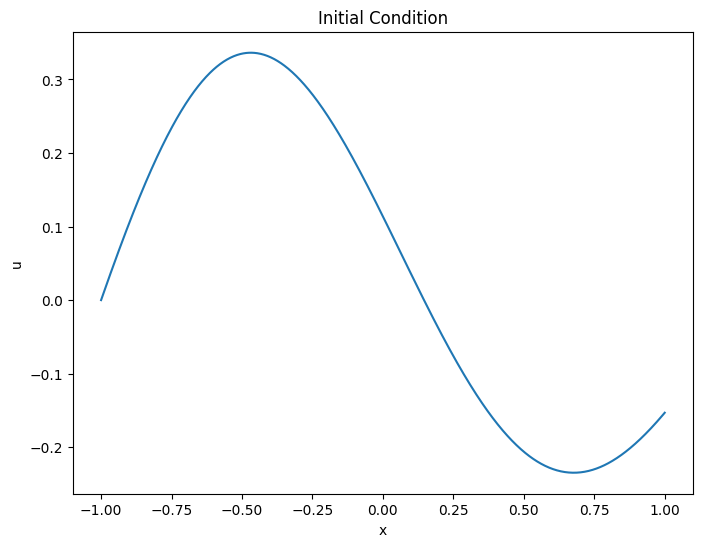

'# Plot the initial condition\nplt.figure(figsize=(8, 6))\nplt.pcolormesh(X, T, U, shading=\'auto\')\nplt.colorbar()\nplt.xlabel(\'x\')\nplt.ylabel(\'t\')\nplt.title("Burger\'s Equation Solution")\nplt.show()'

In [5]:
X, T = np.meshgrid(x, t)

# Initial condition
u0 = -np.sin(np.pi * x)

# Generate the dataset
def burgers_exact(x, t, nu):
    return -2 * nu * np.pi * np.sin(np.pi * (x - 4 * nu * t)) * np.exp(-np.pi**2 * nu * t)
# Exact solution: u(x, t) = -2 * nu * pi * sin(pi * (x - 4 * nu * t)) * exp(-pi^2 * nu * t)
# If t = 0, u(x, 0) = -2 * nu * pi * sin(pi * x) = -2 * 0.01/pi * pi * sin(pi * x) = -0.02 * sin(pi * x)
# If t = 1, u(x, 1) = -2 * nu * pi * sin(pi * (x - 4 * nu)) = -2 * 0.01/pi * pi * sin(pi * (x - 4 * 0.01/pi)) = -0.02 * sin(pi * (x - 4 * 0.01/pi))

U_1D = burgers_exact(x, t, nu)
U = burgers_exact(X, T, nu)

# Plot sizes of all the data
print("x shape:", x.shape)
print("t shape:", t.shape)
print("u0:", u0.shape)
print("U_1D shape:", U_1D.shape)
print("X shape:", X.shape)
print("T shape:", T.shape)
print("U shape:", U.shape)

plt.figure(figsize=(8, 6))
plt.plot(x, U_1D)
plt.xlabel('x')
plt.ylabel('u')
plt.title('Initial Condition')
plt.show()

'''# Plot the initial condition
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, T, U, shading='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Burger's Equation Solution")
plt.show()'''

In [6]:
def a_pinn(model, x, t, u, nu):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x)
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            #u = model.forward(tf.concat([x], axis=1))
            u = model.forward(x)
        u_x = tape.gradient(u, x)
    u_xx = tape2.gradient(u_x, x)
    #u_t = tape.gradient(u, t)
    residual = u * u_x - nu * u_xx
    return residual

def n_pinn(model, x, t, u, nu, scheme):
    dx = x[1] - x[0] # Assuming uniform grid  
    xE, xW = x + dx, x - dx
    uE, uW = model.forward(xE), model.forward(xW)

    if scheme == 'uw1':
        u_x = (u - uW) / (x - xW)
        u_xx = (uE - 2 * u + uW) / (x - xW)**2
    elif scheme == 'uw2':
        uWW = model.forward(x - 2 * dx)
        u_x = (3 * u - 4 * uW + uWW) / (2 * dx)
        uEE = model.forward(x + 2 * dx)
        u_xx = (-uEE + 4 * uE - 5 * u + 2 * uW) / dx**2

    residual = u * u_x - nu * u_xx
    return residual

def can_pinn(model, x, t, u, nu, scheme):
    dx = x[1] - x[0]
    PDE_step = 5
    dx = dx * PDE_step
    xE, xW = x + dx, x - dx # u(x-dx) = uW, u(x) = u, u(x+dx) = uE
    uE, uW = model.forward(xE), model.forward(xW)

    if scheme == 'uw1':
        '''uE, uW = model.forward(xE), model.forward(xW)
        a1, a2, a3 = 1, a1 * dx / 2, a1 * dx**2 / 3
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(xE, xW)
        uE_x, uW_x = tape.gradient(uE, xE), tape.gradient(uW, xW)'''

    elif scheme == 'uw2':
        
        with tf.GradientTape(persistent=True) as tape2_xE, tf.GradientTape(persistent=True) as tape2_xW, tf.GradientTape(persistent=True) as tape2_x:
            tape2_xE.watch(xE)
            tape2_xW.watch(xW)
            tape2_x.watch(x)
            with tf.GradientTape(persistent=True) as tape_xE, tf.GradientTape(persistent=True) as tape_xW, tf.GradientTape(persistent=True) as tape_x:
                tape_xE.watch(xE)
                tape_xW.watch(xW)
                tape_x.watch(x)
                uE, uW, u = model.forward(xE), model.forward(xW), model.forward(x)
            uE_x, uW_x, u_x = tape_xE.gradient(uE, xE), tape_xW.gradient(uW, xW), tape_x.gradient(u, x)
        uE_xx, uW_xx, u_xx = tape2_xE.gradient(uE_x, xE), tape2_xW.gradient(uW_x, xW), tape2_x.gradient(u_x, x)

        uEm_uw2 = u + u_x*dx/2
        uEp_uw2 = uE - uE_x*dx/2
        uWm_uw2 = uW + uW_x*dx/2
        uWp_uw2 = u - u_x*dx/2
        #uE_uw2 = tf.where(u_x > 0, uEm_uw2, uEp_uw2)
        #uW_uw2 = tf.where(u_x > 0, uWm_uw2, uWp_uw2)
        uE_uw2 = tf.where(tf.greater_equal(u_x, 0.0), uEm_uw2, uEp_uw2)
        uW_uw2 = tf.where(tf.greater_equal(u_x, 0.0), uWm_uw2, uWp_uw2)    
        u_uw2 = (uE_uw2 + uW_uw2) / 2
        u_x_uw2 = (uE_uw2 - uW_uw2) / dx

        uEm_x_uw2 = u_x + u_xx * dx / 2
        uEp_x_uw2 = uE_x - uE_xx * dx / 2
        uWm_x_uw2 = uW_x + uW_xx * dx / 2
        uWp_x_uw2 = u_x - u_xx * dx / 2
        #uE_x_uw2 = tf.where(u_x > 0, uEm_x_uw2, uEp_x_uw2)
        #uW_x_uw2 = tf.where(u_x > 0, uWm_x_uw2, uWp_x_uw2)
        uE_x_uw2 = tf.where(tf.greater_equal(u_x, 0.0), uEm_x_uw2, uEp_x_uw2)
        uW_x_uw2 = tf.where(tf.greater_equal(u_x, 0.0), uWm_x_uw2, uWp_x_uw2) 
        u_xx_uw2 = (uE_x_uw2 - uW_x_uw2) / dx

    residual = u_uw2 * u_x_uw2 - nu * u_xx_uw2
    
    # save first and second terms of residual into a dataframe
    first_term = u_uw2 * u_x_uw2
    second_term = nu * u_xx_uw2

    return residual, first_term, second_term, u_uw2, u_x_uw2


def pinn_loss(model, x, t, u0, nu):
    # Initial condition loss
    #u_pred_initial = model.forward(tf.concat([x, tf.zeros_like(x)], axis=1))
    #loss_initial = tf.reduce_mean(tf.square(u_pred_initial - u0))

    # Boundary condition loss
    #u_pred_left = model.forward(tf.concat([tf.ones_like(t) * x[0], t], axis=1))
    #u_pred_right = model.forward(tf.concat([tf.ones_like(t) * x[-1], t], axis=1))
    #loss_boundary = tf.reduce_mean(tf.square(u_pred_left)) + tf.reduce_mean(tf.square(u_pred_right))
    u_pred_left = model.forward([x[0]])
    u_pred_right = model.forward([x[-1]])
    loss_boundary = tf.reduce_mean(tf.square(u_pred_left)) + tf.reduce_mean(tf.square(u_pred_right))
    #loss_boundary = tf.reduce_mean(tf.square(u_pred_left - 0)) + tf.reduce_mean(tf.square(u_pred_right - 0))

    '''# PDE residual loss
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_pred = model(tf.concat([x, t], axis=1))
    residual = pde_residual(u_pred, x, t, nu)
    loss_pde = tf.reduce_mean(tf.square(residual))'''

    # Total loss
    total_loss = loss_boundary 
    return total_loss

In [7]:
Y = burgers_exact(x, t, nu)
X = x
Y = Y.reshape(-1, 1).astype(np.float32)
X = X.reshape(-1, 1).astype(np.float32)
hidden1 = N

X_tf shape: (1000, 1)
X_tf type: float32
Y_tf shape: (1000, 1)
Y_tf type: float32


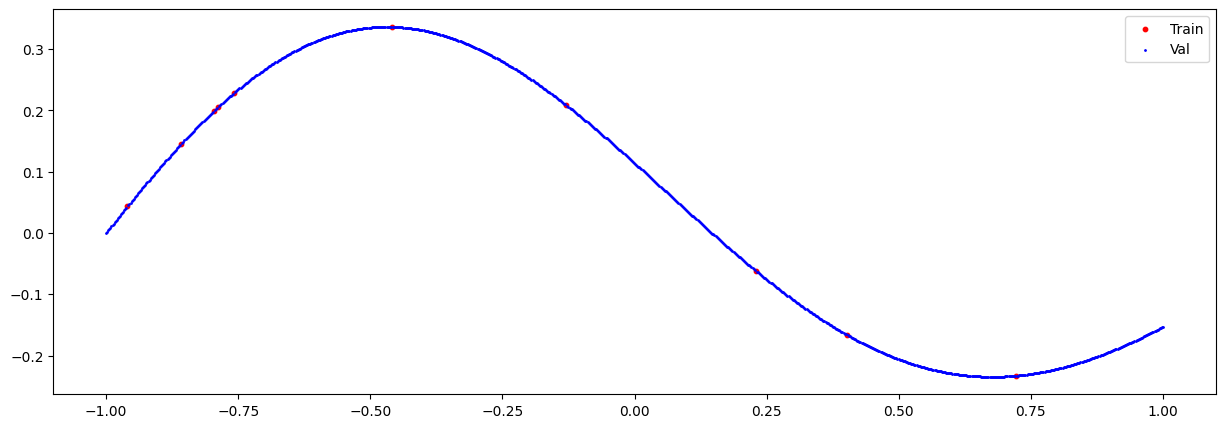

Epoch 1 --- Loss = 104.180443 --- Loss components: Data 104.17747497558594, PDE 0.0029703364707529545
RMSE: 0.1520167142
Improved RMSE. Saved weights and biases.
Epoch 2 --- Loss = 79.926941 --- Loss components: Data 79.91510772705078, PDE 0.011834479868412018
RMSE: 0.1322841346
Improved RMSE. Saved weights and biases.
Epoch 3 --- Loss = 61.305309 --- Loss components: Data 61.302635192871094, PDE 0.0026752669364213943
RMSE: 0.1165767759
Improved RMSE. Saved weights and biases.
Epoch 4 --- Loss = 51.565613 --- Loss components: Data 51.563106536865234, PDE 0.0025074942968785763
RMSE: 0.1169507131
Epoch 5 --- Loss = 39.793068 --- Loss components: Data 39.78464126586914, PDE 0.008427929133176804
RMSE: 0.1230397373
Epoch 6 --- Loss = 32.368790 --- Loss components: Data 32.363162994384766, PDE 0.005628511775285006
RMSE: 0.1203508824
Epoch 7 --- Loss = 26.163418 --- Loss components: Data 26.160663604736328, PDE 0.0027540705632418394
RMSE: 0.1164254174
Improved RMSE. Saved weights and biases.


KeyboardInterrupt: 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the neural network architecture
class BayesianNeuralNetwork:
    def __init__(self, input_dim, hidden1, hidden2, output_dim, dropout_rate=0., prior_std=1.0):
        # Initialize weights and biases as TensorFlow variables
        initializer = tf.initializers.GlorotUniform()

        # Define trainable parameters (weights and biases)
        self.weights = [
            tf.Variable(initializer([input_dim, hidden1]), dtype=tf.float32),
            tf.Variable(initializer([hidden1, hidden2]), dtype=tf.float32),
            tf.Variable(initializer([hidden2, output_dim]), dtype=tf.float32)
        ]
        
        self.biases = [
            tf.Variable(tf.zeros([hidden1]), dtype=tf.float32),
            tf.Variable(tf.zeros([hidden2]), dtype=tf.float32),
            tf.Variable(tf.zeros([output_dim]), dtype=tf.float32)
        ]

        # Prior parameters (assuming Gaussian priors)
        self.prior_std = prior_std
        self.prior_vars = [
            tf.constant(self.prior_std**2, dtype=tf.float32) for _ in self.weights + self.biases]
        
        self.dropout_rate = dropout_rate

    def forward(self, X, training=True):
        # Layer 1 with tanh activation
        hidden1 = tf.matmul(X, self.weights[0]) + self.biases[0]
        hidden1_activation = tf.nn.tanh(hidden1)
        if training:
            hidden1_activation = tf.nn.dropout(hidden1_activation, rate=self.dropout_rate)
        
        # Layer 2 with tanh activation
        hidden2 = tf.matmul(hidden1_activation, self.weights[1]) + self.biases[1]
        hidden2_activation = tf.nn.tanh(hidden2)
        if training:
            hidden2_activation = tf.nn.dropout(hidden2_activation, rate=self.dropout_rate)
        
        # Output layer (linear activation)
        output = tf.matmul(hidden2_activation, self.weights[2]) + self.biases[2]
        return output
    
    def log_prior(self): # Role: Define initial beliefs about each parameter, acting as regularizers.
        # Compute log prior probability of weights and biases
        log_prior = 0.0
        for var, var_prior_var in zip(self.weights + self.biases, self.prior_vars): 
            # Assuming Gaussian prior: log p(w) = -0.5 * log(2πσ²) - w²/(2σ²)
            #log_prior += -0.5 * tf.reduce_sum(tf.math.log(2.0 * np.pi * var_prior_var**2)) # log(2πσ²)
            log_prior += -tf.reduce_sum(tf.square(var)) / (2.0 * var_prior_var**2) # -w²/(2σ²)
        log_prior_store.append(log_prior)
        return log_prior

    def log_likelihood(self, Y_true, Y_pred): # Role: Represents the probability of observing the data given the parameters, modeling how well the network fits the data.
        # Assuming Gaussian likelihood: p(Y|X,w) = N(Y_pred, σ²)
        # log p(Y|X,w) = -0.5 * log(2πσ²) - (Y - Y_pred)^2 / (2σ²)
        #log_likelihood = -0.5 * tf.cast(tf.size(Y_true), tf.float32) * tf.math.log(2.0 * np.pi * likelihood_std**2) # log(2πσ²)
        likelihood_std = np.std(Y_pred)
        log_likelihood = 0.0
        log_likelihood += -tf.reduce_sum(tf.square(Y_true - Y_pred)) / (2.0 * likelihood_std**2) # -(Y - Y_pred)^2 / (2σ²)
        log_likelihood_store.append(log_likelihood)
        return log_likelihood

    def log_posterior(self, Y_true, Y_pred): # Role: Combines priors and likelihood to update beliefs about parameters after observing the data.
        # log posterior ∝ log likelihood + log prior
        #print("Likelihood:   ", self.log_likelihood(Y_true, Y_pred))
        #print("Prior:   ", self.log_prior())
        log_posterior_store.append(self.log_likelihood(Y_true, Y_pred) + self.log_prior())
        return self.log_likelihood(Y_true, Y_pred) + self.log_prior()

# Define the loss function (negative log posterior)
def negative_log_posterior(model, Y_true, Y_pred):
    # We minimize the negative log posterior
    return -model.log_posterior(Y_true, Y_pred)

# Initialize the Bayesian neural network
input_dim = 1
hidden1 = 256
hidden2 = 256
output_dim = 1

model = BayesianNeuralNetwork(input_dim, hidden1, hidden2, output_dim)

# Prepare the optimizer
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)  # Adam often works better for Bayesian methods

# Training parameters
epochs = 2000
print_interval = 1
best_rmse = float('inf')
loss_all = []
loss_all_pde = []
loss_all_conditions = []
loss_all_data = []
first_term_all = []
second_term_all = []
val_loss_all = []
u_uw2_all = []
u_x_uw2_all =[]
log_prior_store = []
log_likelihood_store = []
log_posterior_store = []
loss_posterior_all = []
val_posterior_all = []

# Convert data to TensorFlow tensors
#X_tf = tf.convert_to_tensor(X)
#Y_tf = tf.convert_to_tensor(Y)
X_tf = X
Y_tf = Y
print('X_tf shape:', X_tf.shape)
print('X_tf type:', X_tf.dtype)
print('Y_tf shape:', Y_tf.shape)
print('Y_tf type:', Y_tf.dtype)

# Convert data to TensorFlow tensors
# min-max scaling
#Xmin = np.min(X_tf, axis=0)
#Xmax = np.max(X_tf, axis=0)
#Ymin = np.min(Y_tf, axis=0)
#Ymax = np.max(Y_tf, axis=0)
#X_tf = (X_tf - Xmin)/(Xmax - Xmin)
#Y_tf = (Y_tf - Ymin)/(Ymax - Ymin)

# Do normalization
#X_tf = (X_tf - np.mean(X_tf, axis=0)) / np.std(X_tf, axis=0)
#Y_tf = (Y_tf - np.mean(Y_tf, axis=0)) / np.std(Y_tf, axis=0)

'''
# without batch size
for epoch in range(1, epochs + 1):

    with tf.GradientTape() as tape:
        # Forward pass
        Y_pred = model.forward(X_tf)
        loss_data = tf.reduce_mean(tf.square(Y_tf - Y_pred))
        residual, first_term, second_term = can_pinn(model, X_tf, T, Y_tf, nu, 'uw2')
        # save first and second terms of residual into a dataframe for every epoch
        first_term_all.append(first_term)  
        second_term_all.append(second_term)
        loss_pde = tf.reduce_mean(tf.square(residual))
        loss_conditions = pinn_loss(model, X_tf, T, u0, nu)
        
        alpha = max(0.1, 1 - epoch / 1000)  # Decrease over time
        beta = min(1.0, epoch / 1000)       # Increase over time
        loss = loss_data * alpha + loss_pde * beta #+ loss_conditions        loss_all_data.append(loss_data)
        loss_all_data.append(loss_data)
        loss_all_pde.append(loss_pde)
        loss_all_conditions.append(loss_conditions)
        loss_all.append(loss)
    
    # Compute gradients
    loss_chosen = loss
    gradients = tape.gradient(loss_chosen, model.weights + model.biases) # Purpose of gradient: To update the weights and biases in the direction that minimizes the loss function.
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model.weights + model.biases))
    
    # Print loss every 'print_interval' epochs
    if epoch % print_interval == 0 or epoch == 1:
        print(f'Epoch {epoch} --- Loss = {loss_chosen.numpy():.6f}')   
        rmse_train = tf.sqrt(tf.reduce_mean((Y_tf - Y_pred)**2))
        print(f"RMSE: {rmse_train.numpy():.10f} --- loss_data: {loss_data.numpy():.10f} --- loss_pde: {loss_pde.numpy():.10f} --- conditions: {loss_conditions.numpy():.10f}")

    # Save weights and biases only if lower rmse than before
    if rmse_train < best_rmse:
        best_rmse = rmse_train
        MAP_weights = model.weights
        MAP_biases = model.biases
        best_epoch = epoch
        if epoch % print_interval == 0 or epoch == 1:
            #print("Improvement in RMSE. Weights and biases saved.")
            print("----------------------------------------")
    else:
        if epoch % print_interval == 0 or epoch == 1:
            print("No improvement in RMSE. Weights and biases not saved.")
            print("----------------------------------------")
            '''
    
# with batch size

batch_size = 32  # Define batch size
num_batches = math.ceil(X_tf.shape[0] / batch_size)

# Create batches using tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_tf, Y_tf))
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)
# Create batches using tf.data.Dataset without shuffling
#dataset = tf.data.Dataset.from_tensor_slices((X_tf, Y_tf)).batch(batch_size, drop_remainder=True)

# Split the data into training and validation sets using scikit-learn
X_train, X_val, Y_train, Y_val = train_test_split(X_tf, Y_tf, test_size=0.99, random_state=42)

# Create batches for training and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

# Plot the train and val dataset for u, v, p in a subplot for both train and val
plt.figure(figsize=(15, 5))
plt.scatter(X_train, Y_train, c='r', label='Train', s=10)  # s sets the marker size
plt.scatter(X_val, Y_val, c='b', label='Val', s=1)
plt.legend()
plt.show()

'''
# Training loop with validation
with tf.device('/device:GPU:0'):
    for epoch in range(1, epochs + 1):
        # Training step
        for step, (X_batch, Y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                Y_pred = model.forward(X_batch, training=True)
                loss_data = tf.reduce_mean(tf.square(Y_batch - Y_pred))
                residual, first_term, second_term, u_uw2, u_x_uw2 = can_pinn(model, X_batch, T, Y_batch, nu, 'uw2')
                first_term_all.append(first_term)  
                second_term_all.append(second_term)
                u_uw2_all.append(u_uw2)
                u_x_uw2_all.append(u_x_uw2)
                loss_pde = tf.reduce_mean(tf.square(residual)) 
                #loss_pde = nt_pinn(model, X_batch, T, Y_batch, nu, 'uw2')
                #loss_conditions = loss_condition(model, X_batch, T, Y_batch, initial_data)
                loss = loss_data + loss_pde
            
            gradients = tape.gradient(loss, model.weights + model.biases)
            clipped_gradients = [tf.clip_by_value(g, -1.0, 1.0) for g in gradients]
            optimizer.apply_gradients(zip(clipped_gradients, model.weights + model.biases))

        loss_data /= num_batches
        loss_pde /= num_batches
        #loss_conditions /= num_batches
        loss /= num_batches
        loss_all_data.append(loss_data)
        loss_all_pde.append(loss_pde)
        #loss_all_conditions.append(loss_conditions)
        loss_all.append(loss)

        # Validation step
        val_loss = 0
        for X_val_batch, Y_val_batch in val_dataset:
            Y_val_pred = model.forward(X_val_batch, training=False)
            val_loss += tf.reduce_mean(tf.square(Y_val_batch - Y_val_pred))
        val_loss /= num_batches
        val_loss_all.append(val_loss)

        if epoch % print_interval == 0 or epoch == 1:
            print(f'Epoch {epoch} --- Loss = {loss.numpy():.6f} --- Validation Loss = {val_loss.numpy():.6f} --- Loss components: Data {loss_data.numpy()}, PDE {loss_pde.numpy()}')#, Conditions {loss_conditions.numpy()}')
            rmse_train = tf.sqrt(tf.reduce_mean((Y_tf - model.forward(X_tf))**2))
            print(f"RMSE: {rmse_train.numpy():.10f}")

            if rmse_train < best_rmse:
                best_rmse = rmse_train
                MAP_weights = model.weights
                MAP_biases = model.biases
                best_epoch = epoch
                print("Improved RMSE. Saved weights and biases.")
                '''


# Convert tensor
X_tf = tf.convert_to_tensor(X)
Y_tf = tf.convert_to_tensor(Y)

with tf.device('/device:GPU:0'):
    for epoch in range(1, epochs + 1):
        for step, (X_batch, Y_batch) in enumerate(dataset):
            residual, first_term, second_term, u_uw2, u_x_uw2 = can_pinn(model, X_batch, T, Y_batch, nu, 'uw2')
            first_term_all.append(first_term)  
            second_term_all.append(second_term)
            u_uw2_all.append(u_uw2)
            u_x_uw2_all.append(u_x_uw2)
            loss_pde = tf.reduce_mean(tf.square(residual)) 
            with tf.GradientTape() as tape:
                # Forward pass with current batch
                Y_pred = model.forward(X_batch)
                loss_posterior = negative_log_posterior(model, Y_batch, Y_pred)
                loss_data = loss_posterior
                #loss_data = tf.reduce_mean(tf.square(Y_batch - Y_pred))
                #loss_pde = nt_pinn(model, X_batch, T, Y_batch, nu, 'uw2')
                
                #loss_pde = nt_pinn(model, X_batch, T, Y_batch, nu, 'uw2')
                #loss_conditions = loss_condition(model, X_batch, T, Y_batch, initial_data)
                loss = loss_data + loss_pde #* 0.1
            loss_all_data.append(loss_data)
            loss_all_pde.append(loss_pde)
            #loss_all_conditions.append(loss_conditions)
            loss_all.append(loss)
                
                # Debugging loss values
            if tf.math.is_nan(loss):
                print(f"NaN detected in loss at Epoch {epoch}, Step {step}")
                print(f"Loss components: Data {loss_data.numpy()}, PDE {loss_pde.numpy()}")#, Conditions {loss_conditions.numpy()}")
                raise ValueError("NaN in loss function")
    
            # Compute and clip gradients
            gradients = tape.gradient(loss, model.weights + model.biases)
            optimizer.apply_gradients(zip(gradients, model.weights + model.biases))
        
        # Print epoch summary
        if epoch % print_interval == 0 or epoch == 1:
            print(f'Epoch {epoch} --- Loss = {loss.numpy():.6f} --- Loss components: Data {loss_data.numpy()}, PDE {loss_pde.numpy()}')#, Conditions {loss_conditions.numpy()}')
            rmse_train = tf.sqrt(tf.reduce_mean((Y_tf - model.forward(X_tf))**2))
            print(f"RMSE: {rmse_train.numpy():.10f}")
    
            # Save weights if improvement
            if rmse_train < best_rmse:
                best_rmse = rmse_train
                MAP_weights = model.weights
                MAP_biases = model.biases
                best_epoch = epoch
                print("Improved RMSE. Saved weights and biases.")
                


# After training, plot the model predictions
print(f"Best Epoch at: {best_epoch}")
plt.figure(figsize=(8, 6))
plt.plot(X, Y, alpha=1, label='True Data')
# Sort X for better visualization of the prediction curve
sorted_indices = np.argsort(X.squeeze())
X_sorted = X[sorted_indices]
Y_pred_sorted = Y_pred.numpy()[sorted_indices]
plt.plot(X_sorted, Y_pred_sorted, color='red', label='Model Prediction', linewidth=2)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Bayesian Neural Network Fit to sin(X)")
plt.legend()
plt.show()

Best epoch at:  1000
RMSE: 0.01290261
Loss: 6.31270599


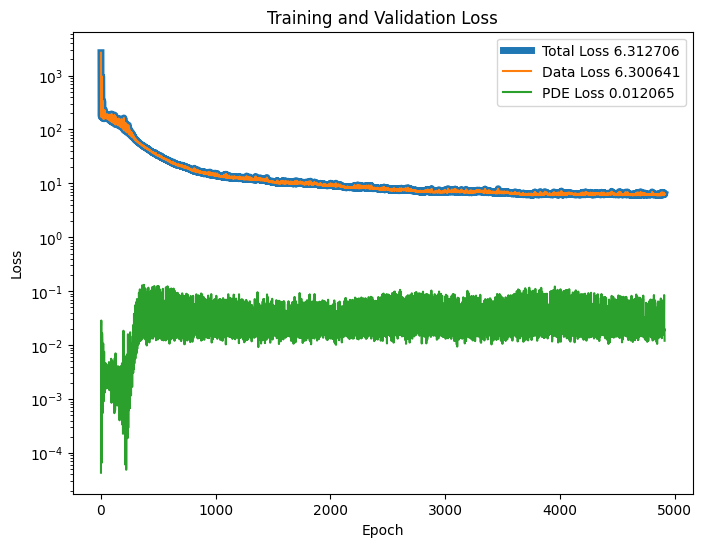

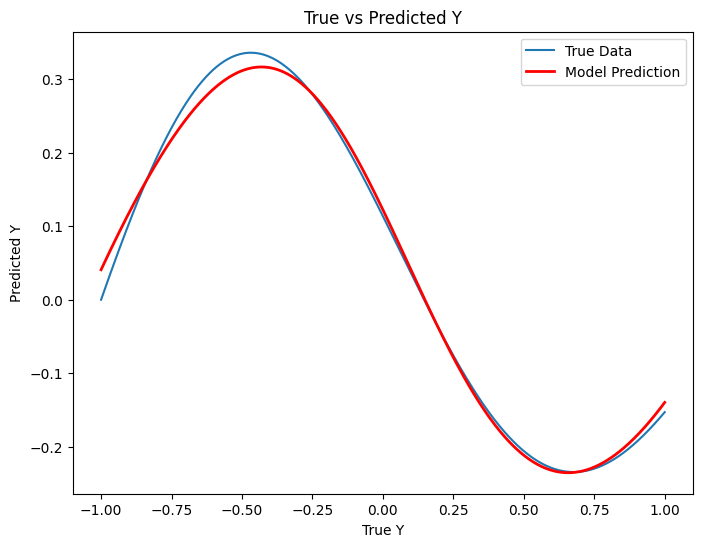

In [21]:
# Print RMSE
model.weights = MAP_weights
model.biases = MAP_biases
U_pred = model.forward(X_tf)
rmse = tf.sqrt(tf.reduce_mean(tf.square(Y_tf - U_pred)))
print("Best epoch at: ", best_epoch)
print(f"RMSE: {rmse.numpy():.8f}")

# Convert loss to anti-log:
print(f"Loss: {(loss.numpy()):.8f}")

# Plot the loss if any of the required loss components are available
plt.figure(figsize=(8, 6))

if loss_all:
    plt.plot(loss_all, linewidth=5, label=f'Total Loss {loss_all[-1].numpy():.6f}')
if loss_all_data:
    plt.plot(loss_all_data, label=f'Data Loss {loss_all_data[-1].numpy():.6f}')
if loss_all_pde:
    plt.plot(loss_all_pde, label=f'PDE Loss {loss_all_pde[-1].numpy():.6f}')
if loss_all_conditions:
    plt.plot(loss_all_conditions, label=f'Conditions Loss {loss_all_conditions[-1].numpy():.6f}')
if val_loss_all:
    plt.plot(val_loss_all, label=f'Validation Loss {val_loss_all[-1].numpy():.6f}')
if loss_posterior_all:
    plt.plot(loss_posterior_all, label=f'Posterior Loss {loss_posterior_all[-1].numpy():.6f}')
plt.axhline(y=0, color='b', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.yscale('log')
# save the plot
plt.show()


# Plot true vs predicted
plt.figure(figsize=(8, 6))
plt.plot(x, Y_tf, alpha=1, label='True Data')
plt.plot(x, U_pred, color='red', label='Model Prediction', linewidth=2)
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.title("True vs Predicted Y")
plt.legend()
plt.show()

In [9]:
# Sampling;

# Initialise MAP from model parameters
model.weights = MAP_weights
model.biases = MAP_biases
MAP = model.weights + model.biases
samples = []; new_sample = []; momentum_norm_total = []; alphas = []; proposed_H_store = []; grad_list_total = []; negative_log_posterior_list_total = []; acceptance_list = []
propose_H = 0
momentum_keep = []; potential_keep = []; current_H_store = [];

# Hyperparameters for HMC
num_samples = 100
step_size = 0.001 # try smaller stepsizes, cfl condition whether the step size is too large
num_leapfrog_steps = 1000   

# Get gradients of the log posterior with respect to the model parameters
def grad_log_posterior(model, X, Y):
    with tf.GradientTape() as tape:
        Y_pred = model.forward(X)
        loss = negative_log_posterior(model, Y, Y_pred)
    return tape.gradient(loss, model.weights + model.biases)

import pickle

# Hamiltonian Monte Carlo sampling
def hmc_sampling(model, X, Y, num_samples, step_size, num_leapfrog_steps):
    samples = [] # List to store samples
    current_sample = MAP # Start from the MAP estimate
    #current_log_prob = negative_log_posterior(model, Y, model.forward(X)).numpy()

    num_accepted = 0
    num_rejected = 0
    with tf.device('/GPU:0'):
        for k in range(num_samples):
            # Sample momentum from a Gaussian distribution
            momentum = [tf.random.normal(w.shape) for w in current_sample]
            '''# Plot momentum distribution
            print("Momentum size:" , momentum[1].numpy().ravel().shape)
            plt.figure(figsize=(10, 5))
            plt.hist(momentum[1].numpy().ravel(), bins=50)
            plt.title('Momentum')
            plt.show()'''

            # Compute the current and proposed log probabilities
            current_H = negative_log_posterior(model, Y, model.forward(X)).numpy() + 0.5 * sum((m**2).numpy().sum() for m in momentum)
            current_H_store.append(current_H)
            
            momentum_norm_list = []
            grad_list = []
            negative_log_posterior_list = []

            # Leapfrog integration
            new_sample = samples[-1] if samples else current_sample
            
            for l in range(num_leapfrog_steps):
                # Make a half step for momentum at the beginning
                momentum = [m - 0.5 * step_size * g for m, g in zip(momentum, grad_log_posterior(model, X, Y))]

                # Make a full step for the position
                new_sample = [w + step_size * m for w, m in zip(new_sample, momentum)]
                new_sample = [tf.Variable(w) for w in new_sample] 
                num_weights = len(new_sample) // 2
                model.weights = new_sample[:num_weights]
                model.biases = new_sample[num_weights:]
                # Make a full step for the momentum, except at the end of the trajectory
                if l < num_leapfrog_steps - 1:
                    momentum = [m - 0.5 * step_size * g for m, g in zip(momentum, grad_log_posterior(model, X, Y))]

                # Calculate the momentum norm for each weight and bias
                momentum_norm = [tf.norm(m).numpy() for m in momentum]
                momentum_norm_list.append(momentum_norm)
                grad_norm = [tf.norm(g).numpy() for g in grad_log_posterior(model, X, Y)]
                grad_list.append(grad_norm)
                negative_log_posterior_list.append(negative_log_posterior(model, Y, model.forward(X)).numpy())  


                #print("Step: ", l+1)
                #print("Momentum Norm: ", momentum_norm)
            '''# Plot momentum norm
            plt.figure(figsize=(10, 5))
            plt.plot(momentum_norm_list)
            plt.title('Momentum Norm')
            plt.show()'''

            # Append momentum norm for every sample
            momentum_norm_total.append(momentum_norm_list)
            grad_list_total.append(grad_list)
            negative_log_posterior_list_total.append(negative_log_posterior_list)
                                
            proposed_H = negative_log_posterior(model, Y, model.forward(X)).numpy() + 0.5 * sum((m**2).numpy().sum() for m in momentum)
            print(negative_log_posterior(model, Y, model.forward(X)).numpy())
            print(0.5 * sum((m**2).numpy().sum() for m in momentum))
            proposed_H_store.append(proposed_H)
            momentum_keep.append(0.5 * sum((m**2).numpy().sum() for m in momentum))
            potential_keep.append(negative_log_posterior(model, Y, model.forward(X)).numpy())

            # Accept or reject the new sample
            p = np.random.uniform()
            alpha = min(1, np.exp(proposed_H - current_H))
            alphas.append(alpha)    
            if p >= alpha: # alpha >= p  or p <= alpha
                print("Accepted")
                num_accepted = num_accepted + 1
                current_sample = new_sample
                samples.append(current_sample)
                acceptreject = 1
            else:
                print("Rejected")
                num_rejected = num_rejected + 1
                current_sample = current_sample
                acceptreject = 0

            # Print p and alpha
            print("p: ", p, " AND alpha: ", alpha)

            # Acceptance rate
            acceptance_rate = 100 * num_accepted / (num_accepted + num_rejected)
            acceptance_list.append(acceptreject)
            print("Acceptance Rate: ", acceptance_rate)
            print("-------------------------- Sample: ", k+1, "--------------------------------")


            # Save all data in a file
            with open('BCANPINN_B_leapfrog_' + str(num_leapfrog_steps) + '.pkl', 'wb') as f:
                pickle.dump(samples, f)
                pickle.dump(momentum_norm_total, f)
                pickle.dump(alphas, f)
                pickle.dump(proposed_H_store, f)
                pickle.dump(current_H_store, f)
                pickle.dump(grad_list_total, f)
                pickle.dump(negative_log_posterior_list_total, f)
                pickle.dump(acceptance_list, f)
                pickle.dump(MAP_weights, f)
                pickle.dump(MAP_biases, f)
                pickle.dump(momentum_keep, f)
                pickle.dump(potential_keep, f)
    
    return samples, momentum_norm_total, alphas, proposed_H_store, current_H_store, grad_list_total, negative_log_posterior_list_total, acceptance_list, momentum_keep, potential_keep

samples, momentum_norm_total, alphas, proposed_H_store, current_H, grad_list_total, negative_log_posterior_list_total, acceptance_list = hmc_sampling(model, X_tf, Y_tf, num_samples, step_size, num_leapfrog_steps)

40954.965
31010.344369888306
Rejected
p:  0.3745401188473625  AND alpha:  1
Acceptance Rate:  0.0
-------------------------- Sample:  1 --------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_13012\1755711152.py:99: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp(proposed_H - current_H))


99649.56
90405.73455810547
Rejected
p:  0.9507143064099162  AND alpha:  1
Acceptance Rate:  0.0
-------------------------- Sample:  2 --------------------------------
173970.33
195452.09368234873
Rejected
p:  0.7319939418114051  AND alpha:  1
Acceptance Rate:  0.0
-------------------------- Sample:  3 --------------------------------
89576.555
89356.69769477844
Accepted
p:  0.5986584841970366  AND alpha:  0.0
Acceptance Rate:  25.0
-------------------------- Sample:  4 --------------------------------
50363.195
74726.60419273376
Rejected
p:  0.15601864044243652  AND alpha:  1
Acceptance Rate:  20.0
-------------------------- Sample:  5 --------------------------------
50116.004
73670.48824119568
Rejected
p:  0.15599452033620265  AND alpha:  1
Acceptance Rate:  16.666666666666668
-------------------------- Sample:  6 --------------------------------
50299.79
75049.5439081192
Rejected
p:  0.05808361216819946  AND alpha:  1
Acceptance Rate:  14.285714285714286
-------------------------- S

ValueError: too many values to unpack (expected 8)